# **IMPORT**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_theme()
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("drive/My Drive/Education/Formation/Datascientest/Projet velo/velo.csv", sep = ';')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 904321 entries, 0 to 904320
Data columns (total 10 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   Identifiant du compteur                  904321 non-null  object 
 1   Nom du compteur                          904321 non-null  object 
 2   Identifiant du site de comptage          904321 non-null  int64  
 3   Nom du site de comptage                  904321 non-null  object 
 4   Comptage horaire                         904321 non-null  float64
 5   Date et heure de comptage                904321 non-null  object 
 6   Date d'installation du site de comptage  904321 non-null  object 
 7   Lien vers photo du site de comptage      904321 non-null  object 
 8   Coordonnées géographiques                904321 non-null  object 
 9   Identifiant technique compteur           895671 non-null  object 
dtypes: float64(1), int64(1), object(

# **PRE-PROCESSING**

## CLEANING

### Suppression valeurs manquantes

* La seule colonne qui comporte des NaN est la colonne 'Identifiant technique compteur', qui comporte 8650 NaN. Tous ces Nan sont liés au site de comptage '35 boulevard de Ménilmontant'.
* Nous avons supprimé la variable ‘Identifiant technique compteur’ dans le DataFrame df parce que cette variable n’est pas essentielle pour nos modèles et les compteurs peuvent déjà être identifiés dans les variables ‘Identifiant du compteur’ et ‘nom du compteur’.

In [1]:
df.isna().sum()

#len(df['Identifiant du site de comptage'].unique())

#df['Identifiant technique compteur'].isna()
#df_nan = df[df['Identifiant technique compteur'].isna()]
#df_nan['Nom du site de comptage'].value_counts()
df = df.drop('Identifiant technique compteur', axis= 1)

NameError: ignored

### Gestion valeurs aberrantes

* Nous pouvons constater une valeur aberrante sur la variable ‘comptage horaire’ avec 2088. (cf box plot ci dessous).
* Nous avons donc décidé de l’éliminer et de limiter la variable ‘comptage horaire’ à 1500.

In [ ]:
plt.figure(figsize=(10,20))
sns.boxplot(y=df['Comptage horaire'], color= 'g')
plt.title('Distribution de la variable Comptage horaire')

In [ ]:
df = df[df['Comptage horaire']<1500]

## NEW VARIABLES

### From dataset

In [ ]:
df['Date'] = df['Date et heure de comptage'].apply(lambda x : x[:10])
df['Date et heure'] = df['Date et heure de comptage'].apply(lambda x : x[:19])

df['Date'] = pd.to_datetime(df['Date'])
df['Date et heure'] = pd.to_datetime(df['Date et heure'])

In [ ]:
df['Jour de la semaine'] = df['Date'].dt.dayofweek
df['Jour de la semaine'] = df['Jour de la semaine'].replace(to_replace = [0,1,2,3,4,5,6], value= ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche'])

In [ ]:
df['Mois'] = df['Date'].dt.month

In [ ]:
df['Heure'] = df['Date et heure'].apply(lambda x: x.hour)

In [ ]:
df['Année'] = df['Date et heure'].apply(lambda x: x.year)

In [ ]:
df['Jour'] = df['Date'].dt.day

In [ ]:
df

### From other sources: jours feriés et vacances


In [ ]:
df_vacances = pd.read_csv("drive/My Drive/Education/Formation/Datascientest/Projet velo/jours off.csv")
df_vacances.date = pd.to_datetime(df_vacances.date)
df_vacances = df_vacances.rename({'date':'Date'}, axis= 1)
df_vacances.info()

### From other sources: temperature et precipitations

Source : https://public.opendatasoft.com/explore/dataset/donnees-synop-essentielles-omm/information/

In [ ]:
df_meteo = pd.read_csv("drive/My Drive/Education/Formation/Datascientest/Projet velo/donnees meteo Orly.csv", sep = ';')

In [ ]:
df_meteo['Date_clean'] = df_meteo['Date'].apply(lambda x : x[:10])
df_meteo['Date_clean'] = pd.to_datetime(df_meteo['Date_clean'])

In [ ]:
df_meteo['Heure_clean']= df_meteo['Date'].apply(lambda x: x[:-6])
df_meteo['Heure_clean']= pd.to_datetime(df_meteo['Heure_clean']).dt.hour

In [ ]:
df_meteo= df_meteo.sort_values(by= ['Date_clean', 'Heure_clean'])

df_meteo= df_meteo.reset_index(drop=True)

df_meteo = df_meteo[['Date_clean', 'Heure_clean', 'Température (°C)', 'Précipitations dans les 3 dernières heures']]
df_meteo= df_meteo.rename(columns= {'Température (°C)': 'Température', 'Précipitations dans les 3 dernières heures': 'Précipitations_3h_passées'})

Remplacement des observations qui valent -0.1 par 0 (pas de sens d'avoir des précipitations negatives)

In [ ]:
df_meteo['Précipitations_3h_passées'] = df_meteo['Précipitations_3h_passées'].replace(to_replace= -0.1, value= 0)

Dates pour lesquelles il manque une heure dans la journée (7 au lieu de 8):
* 2021-12-06
* 2021-01-17
* 2021-12-05
* 2021-04-18
* 2021-02-02

In [ ]:
df_meteo['Heure_clean'].unique()

In [ ]:
df_meteo['Heure_clean'] = df_meteo['Heure_clean'].replace(to_replace= [2,5,8,11,14,17,20,23], value= [1,4,7,10,13,16,19,22])

In [ ]:
df_meteo['Heure_clean'].unique()

In [ ]:
df_meteo['Précipitations_3h_passées'] = df_meteo['Précipitations_3h_passées'].fillna(0)
df_meteo.isna().sum()

In [ ]:
df_meteo['Heure_clean'] = df_meteo['Heure_clean'].astype(str)

In [ ]:
df_meteo['Heure_clean'] = df_meteo['Heure_clean'].apply(lambda x: pd.datetime.strptime(x, '%H').time())

df_meteo

In [ ]:
df_meteo['Date et heure'] = df_meteo.apply(lambda x : pd.datetime.combine(x['Date_clean'],x['Heure_clean']),1)

df_meteo

In [ ]:
df_meteo = df_meteo[['Date et heure', 'Température', 'Précipitations_3h_passées']]
df_meteo

# **MACHINE LEARNING MODELS**

## PRE-PROCESSING

In [ ]:
df_grouped= df.groupby(['Date et heure', 'Date', 'Année', 'Mois', 'Jour', 'Heure'], as_index= False).agg({'Comptage horaire' : 'sum'})
#df_grouped= df.groupby(['Date et heure'], as_index= False).agg({'Comptage horaire' : 'sum'})

In [ ]:
df_grouped['Mois'] = df_grouped['Mois'].replace(to_replace = [1,2,3,4,5,6,7,8,9,10,11,12], value= ['Janvier', 'Fevrier', 'Mars', 'Avril', 'Mai', 'Juin', 'Juillet', 'Aout', 'Septembre', 'Octobre', 'Novembre', 'Decembre'])


In [ ]:
df_grouped

Heures données par le dataframe meteo que l'on va utiliser pour regrouper le dataframe en fenetre horaire de 3h :
* 1 ; 4 ; 7 ; 10 ; 13 ; 16 ; 19 ; 22


In [ ]:
df_grouped = df_grouped.drop([0, 9475])

In [ ]:
df_grouped = df_grouped.reset_index()
df_grouped = df_grouped.drop('index', axis= 1)
df_grouped

**Creation d'un nouveau dataframe avec le comptage horraire groupé par 3h**

In [ ]:
df_grouped_3 = df_grouped.groupby(pd.Grouper(key= 'Date et heure', freq= '180Min', label= 'right', closed= 'right', origin= 'start')).agg({'Date':'first', 'Année':'first', 'Mois':'first', 'Jour':'first', 'Comptage horaire':'sum'})
df_grouped_3 = df_grouped_3.reset_index()
df_grouped_3

,Date et heure,Date,Année,Mois,Jour,Comptage horaire
0,2021-01-01 04:00:00,2021-01-01,2021,Janvier,1,113.0
1,2021-01-01 07:00:00,2021-01-01,2021,Janvier,1,1297.0
2,2021-01-01 10:00:00,2021-01-01,2021,Janvier,1,2430.0
3,2021-01-01 13:00:00,2021-01-01,2021,Janvier,1,7920.0
4,2021-01-01 16:00:00,2021-01-01,2021,Janvier,1,11460.0
...,...,...,...,...,...,...
3154,2022-01-30 10:00:00,2022-01-30,2022,Janvier,30,9100.0
3155,2022-01-30 13:00:00,2022-01-30,2022,Janvier,30,23040.0
3156,2022-01-30 16:00:00,2022-01-30,2022,Janvier,30,30183.0
3157,2022-01-30 19:00:00,2022-01-30,2022,Janvier,30,24183.0


Fusion du dataframe principal (df) avec les 2 dataframes nous permettant d'avoir des informations sur le meteo et sur les jours feries

In [ ]:
df_grouped_3 = df_grouped_3.merge(right= df_vacances, on='Date', how= 'left')

In [ ]:
df_grouped_3 = df_grouped_3.merge(right= df_meteo, on='Date et heure', how= 'left')

In [ ]:
df_grouped_3

In [ ]:
df_grouped_3[df_grouped_3['Température'].isna()]

,Date et heure,Date,Année,Mois,Jour,Comptage horaire,vacance_scolaire,jour_ferie,Température,Précipitations_3h_passées
127,2021-01-17 01:00:00,2021-01-16,2021,Janvier,16,501.0,0,0,NaN,NaN
257,2021-02-02 07:00:00,2021-02-02,2021,Fevrier,2,5909.0,0,0,NaN,NaN
861,2021-04-18 19:00:00,2021-04-18,2021,Avril,18,31713.0,1,0,NaN,NaN
2703,2021-12-05 01:00:00,2021-12-04,2021,Decembre,4,5891.0,0,0,NaN,NaN
2711,2021-12-06 01:00:00,2021-12-05,2021,Decembre,5,2358.0,0,0,NaN,NaN


Gestion des NaN : remplacement par la moyenne de la valeure suivante et precedente :
* ligne 127 : Température= 2.7 ; Précipitations_3h_passées= 0.4
* ligne 257 : Température= 9.7 ; Précipitations_3h_passées= 0.5
* ligne 861 : Température= 10.7 ; Précipitations_3h_passées= 0
* ligne 2703 : Température= 3.9 ; Précipitations_3h_passées= 0.1
* ligne 2711 : Température= 5.6 ; Précipitations_3h_passées= 0.1

In [ ]:
df_grouped_3.iloc[[2710,2711,2712]]

,Date et heure,Date,Année,Mois,Jour,Comptage horaire,vacance_scolaire,jour_ferie,Température,Précipitations_3h_passées
2710,2021-12-05 22:00:00,2021-12-05,2021,Decembre,5,7414.0,0,0,6.0,0.2
2711,2021-12-06 01:00:00,2021-12-05,2021,Decembre,5,2358.0,0,0,NaN,NaN
2712,2021-12-06 04:00:00,2021-12-06,2021,Decembre,6,428.0,0,0,5.2,0.0


In [ ]:
df_grouped_3.loc[2711,'Température']= 5.6
df_grouped_3.loc[2711,'Précipitations_3h_passées']= 0.1

df_grouped_3.loc[2703,'Température']= 3.9
df_grouped_3.loc[2703,'Précipitations_3h_passées']= 0.1

df_grouped_3.loc[861,'Température']= 10.7
df_grouped_3.loc[861,'Précipitations_3h_passées']= 0

df_grouped_3.loc[257,'Température']= 9.7
df_grouped_3.loc[257,'Précipitations_3h_passées']= 0.5

df_grouped_3.loc[127,'Température']= 2.7
df_grouped_3.loc[127,'Précipitations_3h_passées']= 0.4

In [ ]:
df_grouped_3['Heure']= df_grouped_3['Date et heure'].dt.hour
df_grouped_3

,Date et heure,Date,Année,Mois,Jour,Comptage horaire,vacance_scolaire,jour_ferie,Température,Précipitations_3h_passées,Heure
0,2021-01-01 04:00:00,2021-01-01,2021,Janvier,1,113.0,1,1,-1.9,0.0,4
1,2021-01-01 07:00:00,2021-01-01,2021,Janvier,1,1297.0,1,1,-1.2,0.0,7
2,2021-01-01 10:00:00,2021-01-01,2021,Janvier,1,2430.0,1,1,-0.7,0.2,10
3,2021-01-01 13:00:00,2021-01-01,2021,Janvier,1,7920.0,1,1,3.8,0.0,13
4,2021-01-01 16:00:00,2021-01-01,2021,Janvier,1,11460.0,1,1,3.4,0.0,16
...,...,...,...,...,...,...,...,...,...,...,...
3154,2022-01-30 10:00:00,2022-01-30,2022,Janvier,30,9100.0,0,0,7.5,0.0,10
3155,2022-01-30 13:00:00,2022-01-30,2022,Janvier,30,23040.0,0,0,9.8,0.0,13
3156,2022-01-30 16:00:00,2022-01-30,2022,Janvier,30,30183.0,0,0,9.2,0.0,16
3157,2022-01-30 19:00:00,2022-01-30,2022,Janvier,30,24183.0,0,0,7.4,0.0,19


In [ ]:
df_grouped_3 = df_grouped_3.drop(['Date et heure', 'Date'], axis= 1)

In [ ]:
df_grouped_3

,Année,Mois,Jour,Comptage horaire,vacance_scolaire,jour_ferie,Température,Précipitations_3h_passées,Heure
0,2021,Janvier,1,113.0,1,1,-1.9,0.0,4
1,2021,Janvier,1,1297.0,1,1,-1.2,0.0,7
2,2021,Janvier,1,2430.0,1,1,-0.7,0.2,10
3,2021,Janvier,1,7920.0,1,1,3.8,0.0,13
4,2021,Janvier,1,11460.0,1,1,3.4,0.0,16
...,...,...,...,...,...,...,...,...,...
3154,2022,Janvier,30,9100.0,0,0,7.5,0.0,10
3155,2022,Janvier,30,23040.0,0,0,9.8,0.0,13
3156,2022,Janvier,30,30183.0,0,0,9.2,0.0,16
3157,2022,Janvier,30,24183.0,0,0,7.4,0.0,19


Text(0.5, 1.0, 'Distribution de la variable Comptage horaire groupée sur 3h')

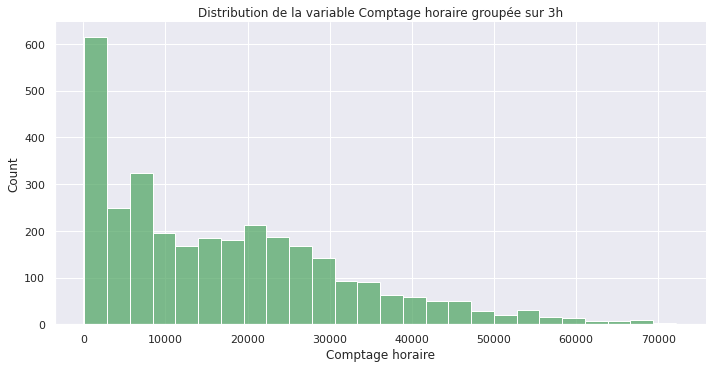

In [ ]:
df_grouped_3['Comptage horaire'].describe()

sns.displot(df_grouped_3['Comptage horaire'], height=5, aspect=2, color= 'g')
plt.title('Distribution de la variable Comptage horaire groupée sur 3h')

Test statistique ANOVA pour verifier que les nouvelles variables ajoutées sont correlées à la variable cible

H0 : on suppose que la variable cible (comptage horraire) est independante des 'nouvelles varables' (vacance_scolaire; jour_ferie; Température; Précipitations_3h_passées)

In [ ]:
df_grouped_3 = df_grouped_3.rename({'Comptage horaire':'Comptage_horaire'}, axis=1)
df_grouped_3

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.api import anova_lm


results = ols('Comptage_horaire ~ vacance_scolaire + jour_ferie + Température + Précipitations_3h_passées', data=df_grouped_3).fit()
table = anova_lm(results)

display(table)

,df,sum_sq,mean_sq,F,PR(>F)
vacance_scolaire,1.0,8.128213e+09,8.128213e+09,46.905491,8.918473e-12
jour_ferie,1.0,4.194313e+09,4.194313e+09,24.204130,9.108537e-07
Température,1.0,1.110006e+11,1.110006e+11,640.551107,8.072826e-129
Précipitations_3h_passées,1.0,4.921983e+09,4.921983e+09,28.403291,1.054271e-07
Residual,3154.0,5.465540e+11,1.732892e+08,NaN,NaN


On rejette l'hypothèse nulle car les p-value des 4 variables sont inferieures à 0.05.


In [ ]:
df_grouped_3 = df_grouped_3.rename({'Comptage_horaire':'Comptage horaire'}, axis=1)
df_grouped_3

,Année,Mois,Jour,Comptage horaire,vacance_scolaire,jour_ferie,Température,Précipitations_3h_passées,Heure
0,2021,Janvier,1,113.0,1,1,-1.9,0.0,4
1,2021,Janvier,1,1297.0,1,1,-1.2,0.0,7
2,2021,Janvier,1,2430.0,1,1,-0.7,0.2,10
3,2021,Janvier,1,7920.0,1,1,3.8,0.0,13
4,2021,Janvier,1,11460.0,1,1,3.4,0.0,16
...,...,...,...,...,...,...,...,...,...
3154,2022,Janvier,30,9100.0,0,0,7.5,0.0,10
3155,2022,Janvier,30,23040.0,0,0,9.8,0.0,13
3156,2022,Janvier,30,30183.0,0,0,9.2,0.0,16
3157,2022,Janvier,30,24183.0,0,0,7.4,0.0,19


Creation d'un nouveau dataframe avec le comptage horraire groupé par 6h

In [ ]:
df_grouped_6 = df_grouped_3.iloc[::2]
df_grouped_6

,Année,Mois,Jour,Comptage horaire,vacance_scolaire,jour_ferie,Température,Précipitations_3h_passées,Heure
0,2021,Janvier,1,113.0,1,1,-1.9,0.0,4
2,2021,Janvier,1,2430.0,1,1,-0.7,0.2,10
4,2021,Janvier,1,11460.0,1,1,3.4,0.0,16
6,2021,Janvier,1,2862.0,1,1,-0.4,0.0,22
8,2021,Janvier,2,147.0,1,0,-2.1,0.0,4
...,...,...,...,...,...,...,...,...,...
3150,2022,Janvier,29,12112.0,0,0,9.1,0.0,22
3152,2022,Janvier,30,3752.0,0,0,8.2,0.0,4
3154,2022,Janvier,30,9100.0,0,0,7.5,0.0,10
3156,2022,Janvier,30,30183.0,0,0,9.2,0.0,16


Creation d'un nouveau dataframe avec le comptage horraire groupé par 9h

In [ ]:
df_grouped_9 = df_grouped_3.iloc[::3]
df_grouped_9

,Année,Mois,Jour,Comptage horaire,vacance_scolaire,jour_ferie,Température,Précipitations_3h_passées,Heure
0,2021,Janvier,1,113.0,1,1,-1.9,0.0,4
3,2021,Janvier,1,7920.0,1,1,3.8,0.0,13
6,2021,Janvier,1,2862.0,1,1,-0.4,0.0,22
9,2021,Janvier,2,904.0,1,0,-2.2,0.0,7
12,2021,Janvier,2,20916.0,1,0,4.3,0.0,16
...,...,...,...,...,...,...,...,...,...
3144,2022,Janvier,29,3201.0,0,0,5.5,0.0,4
3147,2022,Janvier,29,19251.0,0,0,9.0,0.0,13
3150,2022,Janvier,29,12112.0,0,0,9.1,0.0,22
3153,2022,Janvier,30,1363.0,0,0,7.6,0.0,7


### Separation varables explicatives/variable cible

Pour le comptage sur 3h

In [ ]:
target= df_grouped_3['Comptage horaire']
data= df_grouped_3.drop('Comptage horaire', axis= 1)

In [ ]:
target

0         113.0
1        1297.0
2        2430.0
3        7920.0
4       11460.0
         ...   
3154     9100.0
3155    23040.0
3156    30183.0
3157    24183.0
3158     9707.0
Name: Comptage horaire, Length: 3159, dtype: float64

In [ ]:
data = pd.get_dummies(data, columns=['Année', 'Mois', 'Jour', 'Heure'])
data

,vacance_scolaire,jour_ferie,Température,Précipitations_3h_passées,Année_2021,Année_2022,Mois_Aout,Mois_Avril,Mois_Decembre,Mois_Fevrier,Mois_Janvier,Mois_Juillet,Mois_Juin,Mois_Mai,Mois_Mars,Mois_Novembre,Mois_Octobre,Mois_Septembre,Jour_1,Jour_2,Jour_3,Jour_4,Jour_5,Jour_6,Jour_7,Jour_8,Jour_9,Jour_10,Jour_11,Jour_12,Jour_13,Jour_14,Jour_15,Jour_16,Jour_17,Jour_18,Jour_19,Jour_20,Jour_21,Jour_22,Jour_23,Jour_24,Jour_25,Jour_26,Jour_27,Jour_28,Jour_29,Jour_30,Jour_31,Heure_1,Heure_4,Heure_7,Heure_10,Heure_13,Heure_16,Heure_19,Heure_22
0,1,1,-1.9,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,1,1,-1.2,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,1,1,-0.7,0.2,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,1,1,3.8,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,1,1,3.4,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3154,0,0,7.5,0.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
3155,0,0,9.8,0.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
3156,0,0,9.2,0.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
3157,0,0,7.4,0.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0


Pour le comptage sur 6h

In [ ]:
target6= df_grouped_6['Comptage horaire']
data6= df_grouped_6.drop('Comptage horaire', axis= 1)

In [ ]:
data6 = pd.get_dummies(data6, columns=['Année', 'Mois', 'Jour', 'Heure'])
data6

,vacance_scolaire,jour_ferie,Température,Précipitations_3h_passées,Année_2021,Année_2022,Mois_Aout,Mois_Avril,Mois_Decembre,Mois_Fevrier,Mois_Janvier,Mois_Juillet,Mois_Juin,Mois_Mai,Mois_Mars,Mois_Novembre,Mois_Octobre,Mois_Septembre,Jour_1,Jour_2,Jour_3,Jour_4,Jour_5,Jour_6,Jour_7,Jour_8,Jour_9,Jour_10,Jour_11,Jour_12,Jour_13,Jour_14,Jour_15,Jour_16,Jour_17,Jour_18,Jour_19,Jour_20,Jour_21,Jour_22,Jour_23,Jour_24,Jour_25,Jour_26,Jour_27,Jour_28,Jour_29,Jour_30,Jour_31,Heure_4,Heure_10,Heure_16,Heure_22
0,1,1,-1.9,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,1,1,-0.7,0.2,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,1,1,3.4,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
6,1,1,-0.4,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
8,1,0,-2.1,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3150,0,0,9.1,0.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
3152,0,0,8.2,0.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
3154,0,0,7.5,0.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
3156,0,0,9.2,0.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0


Pour le comptage sur 9h

In [ ]:
target9= df_grouped_9['Comptage horaire']
data9= df_grouped_9.drop('Comptage horaire', axis= 1)

In [ ]:
data9 = pd.get_dummies(data9, columns=['Année', 'Mois', 'Jour', 'Heure'])
data9

,vacance_scolaire,jour_ferie,Température,Précipitations_3h_passées,Année_2021,Année_2022,Mois_Aout,Mois_Avril,Mois_Decembre,Mois_Fevrier,Mois_Janvier,Mois_Juillet,Mois_Juin,Mois_Mai,Mois_Mars,Mois_Novembre,Mois_Octobre,Mois_Septembre,Jour_1,Jour_2,Jour_3,Jour_4,Jour_5,Jour_6,Jour_7,Jour_8,Jour_9,Jour_10,Jour_11,Jour_12,Jour_13,Jour_14,Jour_15,Jour_16,Jour_17,Jour_18,Jour_19,Jour_20,Jour_21,Jour_22,Jour_23,Jour_24,Jour_25,Jour_26,Jour_27,Jour_28,Jour_29,Jour_30,Jour_31,Heure_1,Heure_4,Heure_7,Heure_10,Heure_13,Heure_16,Heure_19,Heure_22
0,1,1,-1.9,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,1,1,3.8,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
6,1,1,-0.4,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
9,1,0,-2.2,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
12,1,0,4.3,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3144,0,0,5.5,0.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
3147,0,0,9.0,0.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
3150,0,0,9.1,0.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
3153,0,0,7.6,0.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0


## Problematique de machine learning:

 Compte tenu du fait que notre dataset nous donne le trafic par heure (comptage horaire) des différents compteurs répartis dans Paris, il semble logique que notre problématique soit l’estimation du comptage horaire.
* Cependant, nous avons récupéré les données météo, et ces données ne sont que toutes les 3 heures.
* Notre variable cible sera donc le comptage horaire ajusté sur 3h.
* Nos variables explicatives seront toutes les variables liées à la temporalité, et initialement issues de la variable ‘Date et heure de comptage’ ('Année', 'Mois', 'Jour', 'Heure'), ainsi que les variables liées au jours off (jours fériés et jours de vancances) et liées à la météo (température et précipitation)

## MODELES


### RANDOM FOREST REGRESSOR - comptage 3h

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
model_rf = RandomForestRegressor(n_estimators=10)
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2, random_state=123)

model_rf.fit(X_train, y_train)
pred_model_rf = model_rf.predict(X_test)

In [ ]:
print("score du modele sur l'ensemble d'entrainement :", model_rf.score(X_train, y_train))
print("score du modele sur l'ensemble de test :", model_rf.score(X_test, y_test))

score du modele sur l'ensemble d'entrainement : 0.9588732282024913
score du modele sur l'ensemble de test : 0.7530328583126631


In [ ]:
print("rmse sur l'ensemble de test :", np.sqrt(mean_squared_error(pred_model_rf, y_test)))

rmse sur l'ensemble de test : 7394.267759637755


### LASSO - comptage 3h

In [ ]:
from sklearn.linear_model import Lasso

lasso_r = Lasso(alpha=1)
lasso_r.fit(X_train, y_train)

Lasso(alpha=1)

In [ ]:
lasso_reg = Lasso(alpha=0.1)

lasso_reg.fit(X_train, y_train)

Lasso(alpha=0.1)

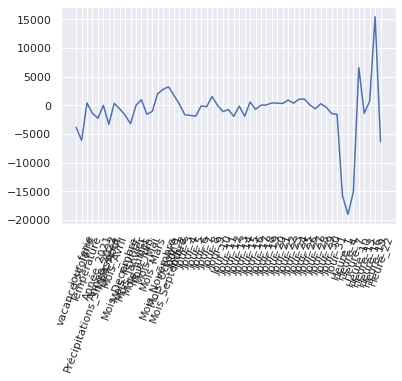

In [ ]:
lasso_coef = lasso_reg.coef_

plt.plot(range(len(data.columns)), lasso_coef)
plt.xticks(range(len(data.columns)), data.columns.values, rotation=70);

In [ ]:
print('score train :', lasso_reg.score(X_train, y_train))
print('score test :', lasso_reg.score(X_test, y_test))

score train : 0.7588491007807319
score test : 0.760009256944636


In [ ]:
lasso_pred_train = lasso_reg.predict(X_train)
lasso_pred_test = lasso_reg.predict(X_test)

print('rmse train :', np.sqrt(mean_squared_error(lasso_pred_train, y_train)))
print('rmse test :', np.sqrt(mean_squared_error(lasso_pred_test, y_test)))

rmse train : 7142.707582833104
rmse test : 7289.081910355816


In [ ]:
from sklearn.linear_model import lasso_path

mes_alphas = (0.001, 0.01, 0.02, 0.025, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0)

alpha_path, coefs_lasso, _ = lasso_path(X_train, y_train, alphas=mes_alphas)

coefs_lasso.shape

(57, 10)

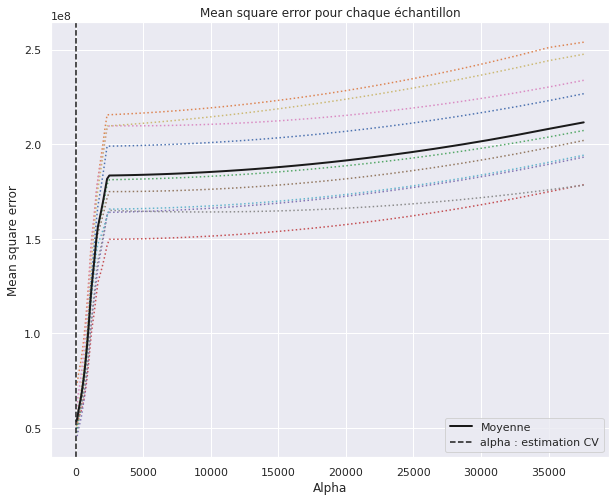

In [ ]:
from sklearn.linear_model import LassoCV

model_lasso = LassoCV(cv=10).fit(X_train, y_train)

alphas = model_lasso.alphas_

plt.figure(figsize=(10, 8))

plt.plot(alphas, model_lasso.mse_path_, ':')
plt.plot(alphas, model_lasso.mse_path_.mean(axis=1), 'k', label='Moyenne', linewidth=2)

plt.axvline(model_lasso.alpha_, linestyle='--', color='k', label='alpha : estimation CV')

plt.xlabel('Alpha')
plt.ylabel('Mean square error')
plt.title('Mean square error pour chaque échantillon')
plt.legend();

In [ ]:
pred_test = model_lasso.predict(X_test)

print('score test :', model_lasso.score(X_test, y_test))
print('rmse test :', np.sqrt(mean_squared_error(pred_test, y_test)))

score test : 0.7676940601311472
rmse test : 7171.429653316045


### ELASTIC NET CV = comptage 3h

In [ ]:
from sklearn.linear_model import ElasticNetCV, ElasticNet


In [ ]:
model_en_cv = ElasticNetCV(l1_ratio=(0.1, 0.25, 0.5, 0.7, 0.75, 0.8, 0.85, 0.9, 0.99), alphas=(0.001, 0.01, 0.02, 0.025, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0), cv= 8)
#model_en = ElasticNet(alpha=0.001, l1_ratio=0.99)

model_en_cv.fit(X_train, y_train)

ElasticNetCV(alphas=(0.001, 0.01, 0.02, 0.025, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0),
             cv=8, l1_ratio=(0.1, 0.25, 0.5, 0.7, 0.75, 0.8, 0.85, 0.9, 0.99))

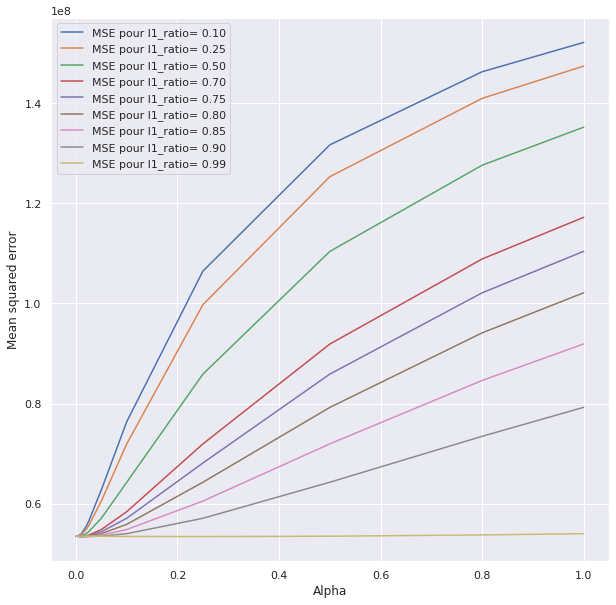

In [ ]:
alphas= model_en_cv.alphas_
model_en_cv.mse_path_.shape

plt.figure(figsize= (10,10))

for i in range(model_en_cv.mse_path_.shape[0]) :
    plt.plot(alphas, model_en_cv.mse_path_[i,:,:].mean(axis=1),
             label='MSE pour l1_ratio= %.2f' %model_en_cv.l1_ratio[i])

plt.xlabel('Alpha')
plt.ylabel('Mean squared error')
plt.legend();

In [ ]:
pred_train_en = model_en_cv.predict(X_train)
pred_test_en = model_en_cv.predict(X_test)

print("rmse sur l'ensemble d'entrainement :", np.sqrt(mean_squared_error(y_train, pred_train_en)))
print("rmse sur l'ensemble de test :", np.sqrt(mean_squared_error(y_test, pred_test_en)))

rmse sur l'ensemble d'entrainement : 7148.498630034897
rmse sur l'ensemble de test : 7281.73843270529


In [ ]:
print("score sur l'ensemble d'entrainement :", model_en_cv.score(X_train, y_train))
print("score sur l'ensemble de test :", model_en_cv.score(X_test, y_test))

score sur l'ensemble d'entrainement : 0.7584579095283425
score sur l'ensemble de test : 0.7604925767701908


### RIDGE CV - comptage 3h

In [ ]:
from sklearn.linear_model import Ridge, RidgeCV


In [ ]:
# Créer un vecteur alphas
alphas = [0.001, 0.01, 0.02, 0.025, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0]

In [ ]:
# Modele de régression Ridge CV
ridge_reg = RidgeCV(alphas)
ridge_reg.fit (X_train, y_train)

RidgeCV(alphas=array([0.001, 0.01 , 0.02 , 0.025, 0.05 , 0.1  , 0.25 , 0.5  , 0.8  ,
       1.   ]))

In [ ]:
# alpha retenu par le modele 
print('alpha sélectionné par RidgeCV :', ridge_reg.alpha_)

# Afficher le score Train (R²)
print ('score Train :', ridge_reg.score(X_train, y_train))

# Afficher le score Test (R²)
print ('score Test :', ridge_reg.score(X_test, y_test))

alpha sélectionné par RidgeCV : 1.0
score Train : 0.758838763165127
score Test : 0.7600956673491209


In [ ]:
# valeurs ajustées du modèle pour X_train
ridge_pred_train = ridge_reg.predict(X_train)

# prédictions du modèle pour X_test
ridge_pred_test = ridge_reg.predict(X_test)

In [ ]:
# Afficher RMSE Train
print('rmse train :', np.sqrt(mean_squared_error(ridge_pred_train, y_train)))

# Afficher RMSE Test
print('rmse test :', np.sqrt(mean_squared_error(ridge_pred_test, y_test)))

rmse train : 7142.860677377433
rmse test : 7287.76954885777


### RIDGE CV - comptage 6h

In [ ]:
X_train6, X_test6, y_train6, y_test6 = train_test_split(data6, target6, test_size = 0.2, random_state=123)

In [ ]:
# Modele de régression Ridge CV
ridge_reg6 = RidgeCV(alphas)
ridge_reg6.fit (X_train6, y_train6)

RidgeCV(alphas=array([0.001, 0.01 , 0.02 , 0.025, 0.05 , 0.1  , 0.25 , 0.5  , 0.8  ,
       1.   ]))

In [ ]:
# alpha retenu par le modele 
print('alpha sélectionné par RidgeCV :', ridge_reg6.alpha_)

# Afficher le score Train (R²)
print ('score Train :', ridge_reg6.score(X_train6, y_train6))

# Afficher le score Test (R²)
print ('score Test :', ridge_reg6.score(X_test6, y_test6))

alpha sélectionné par RidgeCV : 1.0
score Train : 0.6679349297260085
score Test : 0.6784179007361817


In [ ]:
# valeurs ajustées du modèle pour X_train
ridge_pred_train6 = ridge_reg6.predict(X_train6)

# prédictions du modèle pour X_test
ridge_pred_test6 = ridge_reg6.predict(X_test6)

In [ ]:
# Afficher RMSE Train
print('rmse train :', np.sqrt(mean_squared_error(ridge_pred_train6, y_train6)))

# Afficher RMSE Test
print('rmse test :', np.sqrt(mean_squared_error(ridge_pred_test6, y_test6)))

rmse train : 7837.935802397096
rmse test : 7549.286224321652


### RIDGE CV - comptage 9h

In [ ]:
X_train9, X_test9, y_train9, y_test9 = train_test_split(data9, target9, test_size = 0.2, random_state=123)

In [ ]:
# Modele de régression Ridge CV
ridge_reg9 = RidgeCV(alphas)
ridge_reg9.fit (X_train9, y_train9)

RidgeCV(alphas=array([0.001, 0.01 , 0.02 , 0.025, 0.05 , 0.1  , 0.25 , 0.5  , 0.8  ,
       1.   ]))

In [ ]:
# alpha retenu par le modele 
print('alpha sélectionné par RidgeCV :', ridge_reg9.alpha_)

# Afficher le score Train (R²)
print ('score Train :', ridge_reg9.score(X_train9, y_train9))

# Afficher le score Test (R²)
print ('score Test :', ridge_reg9.score(X_test9, y_test9))

alpha sélectionné par RidgeCV : 1.0
score Train : 0.7712149295103525
score Test : 0.8001151228276606


In [ ]:
# valeurs ajustées du modèle pour X_train
ridge_pred_train9 = ridge_reg9.predict(X_train9)

# prédictions du modèle pour X_test
ridge_pred_test9 = ridge_reg9.predict(X_test9)

In [ ]:
# Afficher RMSE Train
print('rmse train :', np.sqrt(mean_squared_error(ridge_pred_train9, y_train9)))

# Afficher RMSE Test
print('rmse test :', np.sqrt(mean_squared_error(ridge_pred_test9, y_test9)))

rmse train : 6898.57472987449
rmse test : 6889.851420971922


### **Tableau comparatif des performances**


In [ ]:
models = pd.DataFrame({'Nom du modèle':['Ridge Regression - 9h', 'Ridge Regression - 6h', 'Ridge Regression - 3h', 'Lasso Regression - 3h', 'Elastic Net - 3h', 'Random Forest Regressor - 3h'], 
                       "Score (R^2) sur l'ensemble de test":[ridge_reg9.score(X_test9, y_test9), ridge_reg6.score(X_test6, y_test6), ridge_reg.score(X_test, y_test), lasso_reg.score(X_test, y_test), model_en_cv.score(X_test, y_test), model_rf.score(X_test, y_test)],
                       "RMSE sur l'ensemble de test": [np.sqrt(mean_squared_error(ridge_pred_test9, y_test9)), np.sqrt(mean_squared_error(ridge_pred_test6, y_test6)), np.sqrt(mean_squared_error(ridge_pred_test, y_test)), np.sqrt(mean_squared_error(lasso_pred_test, y_test)), np.sqrt(mean_squared_error(pred_test_en, y_test)), np.sqrt(mean_squared_error(pred_model_rf, y_test))]})
models

,Nom du modèle,Score (R^2) sur l'ensemble de test,RMSE sur l'ensemble de test
0,Ridge Regression - 9h,0.800115,6889.851421
1,Ridge Regression - 6h,0.678418,7549.286224
2,Ridge Regression - 3h,0.760096,7287.769549
3,Lasso Regression - 3h,0.760009,7289.081910
4,Elastic Net - 3h,0.760493,7281.738433
5,Random Forest Regressor - 3h,0.753033,7394.267760


Text(0.5, 1.0, 'Score des modèles etudiés')

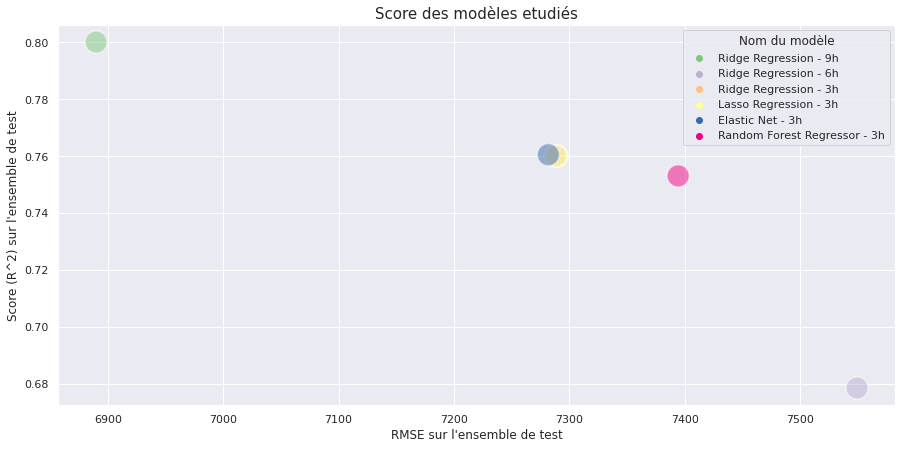

In [ ]:
plt.figure(figsize=(15,7))
sns.scatterplot(x= models["RMSE sur l'ensemble de test"], y=models["Score (R^2) sur l'ensemble de test"], hue= models["Nom du modèle"], palette= 'Accent', s=500, alpha= 0.5)
plt.title("Score des modèles etudiés", size=15)


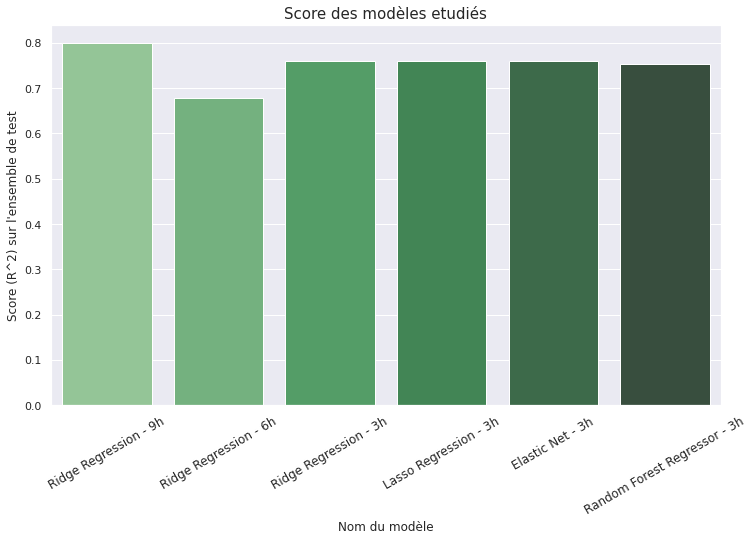

In [ ]:
plt.figure(figsize=(12,7))
sns.barplot(x=models["Nom du modèle"], y=models["Score (R^2) sur l'ensemble de test"], palette= 'Greens_d')
plt.title("Score des modèles etudiés", size=15)
plt.xticks(rotation=30, size=12)
plt.show()


* On remarque que les scores des modèles de regession Ridge, Lasso, Elastic Net et Random Forest sont quasiment identiques sur le comptage de 3h, autour de 0.76. De plus, leur RMSE est aussi quasi identique.

* On a selectionné un des 4 modèle (Ridge) que l'on a fait tourner sur deux autres datasets : le comptage sur une fenetre de 6h et le comptage sur une fenetre de 9h. 

* On remarque que le modèle Ridge est moins performant sur le comptage sur une fenetre de 6h (0.68), par contre il est plus performant sur le comptage sur une fenetre de 9h (0.80).

* On remarque que sur les modèles de Random Forest, il y a du sur-apprentissage car le score sur l'ensemble de test est nettement plus bas que le score sur l'ensemble d'entrainement.


* On peut conclure que le modèle le plus performant est le modèle Ridge appliqué à un jeu de donné qui comporte un comptage du trafic toutes les 9h.

# **DATA VIZ**

## PRE-PROCESSING

In [ ]:
df.info()

In [ ]:
df['Comptage horaire'].describe()

count    904320.000000
mean         59.934115
std          84.517726
min           0.000000
25%           4.000000
50%          29.000000
75%          81.000000
max        1302.000000
Name: Comptage horaire, dtype: float64

In [ ]:
df[df['Nom du compteur'].str.contains('temporaire')]['Nom du compteur'].value_counts()

30 rue Saint Jacques N-S (temporaire)    9476
69 Boulevard Ornano N-S (temporaire)     9476
Name: Nom du compteur, dtype: int64

In [ ]:
df_2021 = df.loc[df['Année'] == 2021]

## GRAPH 1: 2021 per day

In [ ]:
df_jour_2021 = df_2021.groupby('Date', as_index = False).agg({'Comptage horaire' : 'sum'})


In [ ]:
df_jour_2021['Comptage horaire'].mean()

138874.90684931507

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


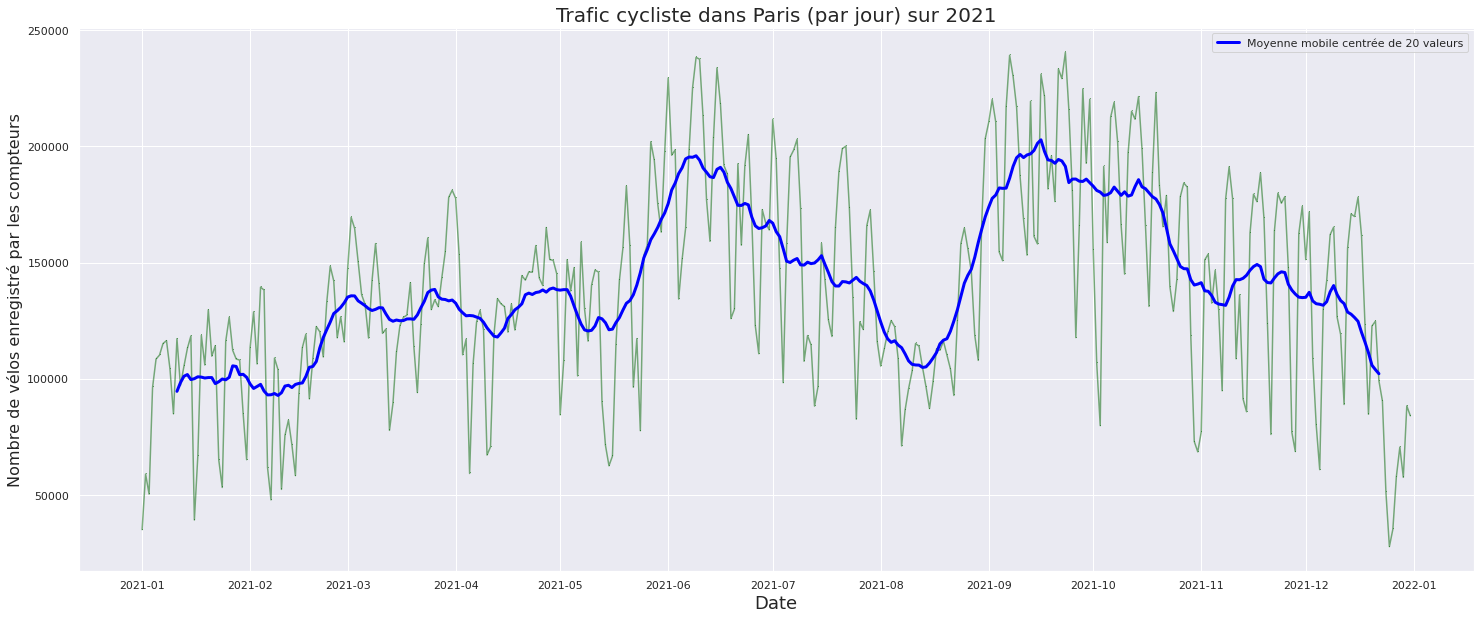

In [ ]:
plt.figure(figsize= (25, 10))
plt.plot_date(x= df_jour_2021['Date'], y= df_jour_2021['Comptage horaire'], xdate= True, ls= '-', color= 'darkgreen', marker= ',', markersize=4, alpha=0.5, label= '')

mmobile = df_jour_2021['Comptage horaire'].rolling(20, center = True).mean()
plt.plot(df_jour_2021['Date'], mmobile, linewidth = 3, color= 'blue', label = "Moyenne mobile centrée de 20 valeurs")

ax = plt.axes()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xlabel('Date', fontsize=18)
plt.ylabel('Nombre de vélos enregistré par les compteurs', fontsize=16)
plt.title('Trafic cycliste dans Paris (par jour) sur 2021', fontsize=20)
plt.legend();

## GRAPH 2: 2021 per month

In [ ]:
df_mois = df_2021.groupby('Mois', as_index = False).agg({'Comptage horaire' : 'sum'})

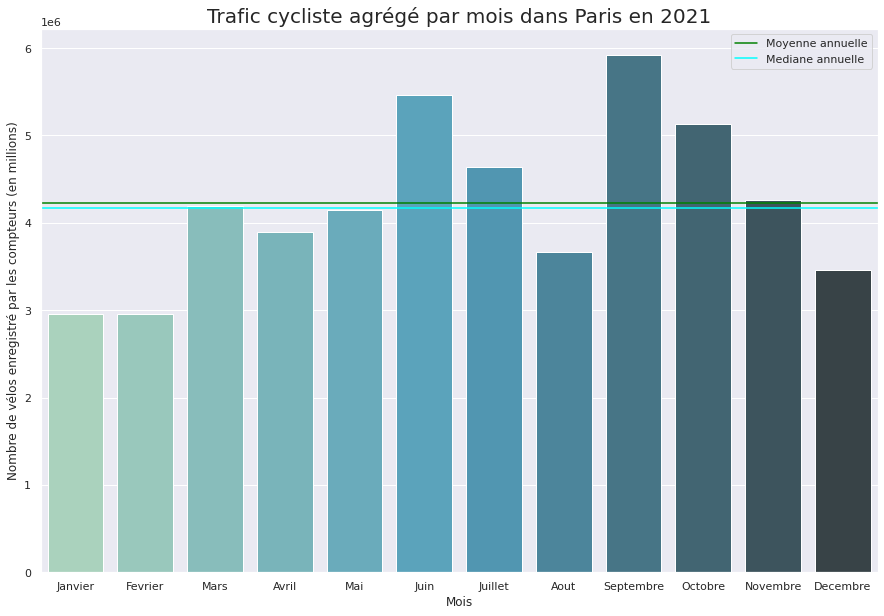

In [ ]:
plt.figure(figsize=(15,10))
sns.barplot(data= df_mois, x= 'Mois', y= 'Comptage horaire', palette= "GnBu_d")
plt.axhline(df_mois['Comptage horaire'].mean(), color= 'green', label= 'Moyenne annuelle')
plt.axhline(df_mois['Comptage horaire'].median(), color= 'cyan', label= 'Mediane annuelle')
plt.title('Trafic cycliste agrégé par mois dans Paris en 2021', fontsize=20)
plt.ylabel("Nombre de vélos enregistré par les compteurs (en millions)")
plt.xticks(ticks= [0,1,2,3,4,5,6,7,8,9,10,11], labels= ['Janvier', 'Fevrier', 'Mars', 'Avril', 'Mai', 'Juin', 'Juillet', 'Aout', 'Septembre', 'Octobre', 'Novembre', 'Decembre'])
plt.legend();


Pour confimer l'hypothese que plus la temperature exterieur est élevée, plus il y a plus de traffic cycliste dans Paris, on peut calculer la moyenne mensuelle du traffic sur les 6 mois les plus chaud de l'année en 2021 (d'apres https://www.historique-meteo.net/france/ile-de-france/paris/2021/) et la comparer avec la moyenne mensuelle des 6 mois les plus froids de l'année:
4,829,997 vs 3,618,575

## GRAPH 3: 2021 per week

In [ ]:
df_jour_semaine = df_2021.groupby('Jour de la semaine', as_index = False).agg({'Comptage horaire' : 'sum'})

In [ ]:
df_jour_semaine['Num jour'] = 1
df_jour_semaine['Num jour'][0] = 7
df_jour_semaine['Num jour'][1] = 4
df_jour_semaine['Num jour'][2] = 1
df_jour_semaine['Num jour'][3] = 2
df_jour_semaine['Num jour'][4] = 3
df_jour_semaine['Num jour'][5] = 6
df_jour_semaine['Num jour'][6] = 5


In [ ]:
df_jour_semaine = df_jour_semaine.sort_values(by= 'Num jour')

In [ ]:
df_jour_semaine

,Jour de la semaine,Comptage horaire,Num jour
2,Lundi,7320590.0,1
3,Mardi,8149739.0,2
4,Mercredi,8137892.0,3
1,Jeudi,8241796.0,4
6,Vendredi,7563717.0,5
5,Samedi,5914200.0,6
0,Dimanche,5361407.0,7


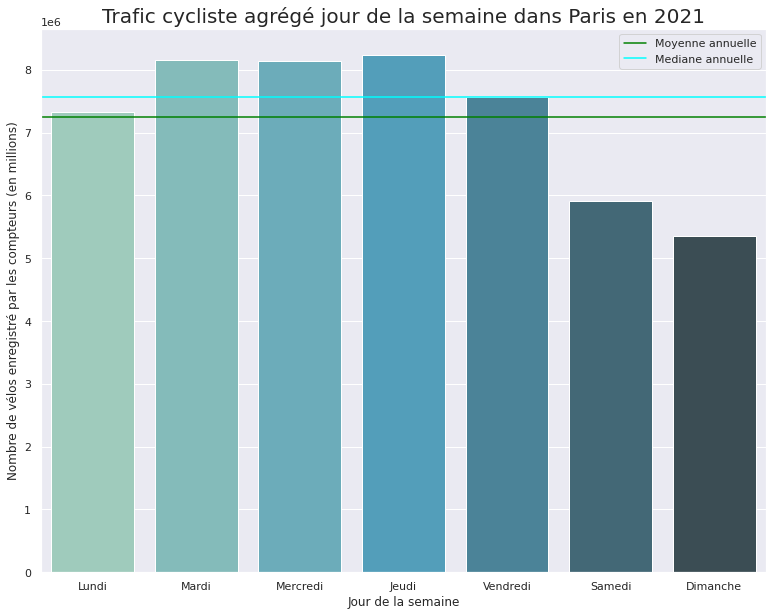

In [ ]:
plt.figure(figsize=(13,10))
sns.barplot(data= df_jour_semaine, x= 'Jour de la semaine', y= 'Comptage horaire', palette= "GnBu_d")
plt.axhline(df_jour_semaine['Comptage horaire'].mean(), color= 'green', label= 'Moyenne annuelle')
plt.axhline(df_jour_semaine['Comptage horaire'].median(), color= 'cyan', label= 'Mediane annuelle')
plt.title('Trafic cycliste agrégé jour de la semaine dans Paris en 2021', fontsize=20)
plt.ylabel("Nombre de vélos enregistré par les compteurs (en millions)")
plt.legend();


Hypothese à tester: il y a plus de traffic en semaine que le weekend

In [ ]:
df_jour_semaine['Weekend']= df_jour_semaine['Num jour'] >= 6

In [ ]:
df_jour_semaine = df_jour_semaine.rename(columns={"Comptage horaire": "Comptage"})


In [ ]:
df_jour_semaine

,Jour de la semaine,Comptage,Num jour,Weekend
2,Lundi,7320590.0,1,False
3,Mardi,8149739.0,2,False
4,Mercredi,8137892.0,3,False
1,Jeudi,8241796.0,4,False
6,Vendredi,7563717.0,5,False
5,Samedi,5914200.0,6,True
0,Dimanche,5361407.0,7,True


In [ ]:
import statsmodels.api

result = statsmodels.formula.api.ols('Comptage ~ Weekend', data = df_jour_semaine).fit()
table = statsmodels.api.stats.anova_lm(result)

table

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,df,sum_sq,mean_sq,F,PR(>F)
Weekend,1.0,7.199672e+12,7.199672e+12,43.065877,0.001232
Residual,5.0,8.358906e+11,1.671781e+11,NaN,NaN


## GRAPH 4: 2021 per hour

In [ ]:
df_heure = df_2021.groupby('Heure', as_index = False).agg({'Comptage horaire' : 'sum'})

In [ ]:
df_heure

In [ ]:
df_heure['Comptage horaire'].mean()

2112055.875

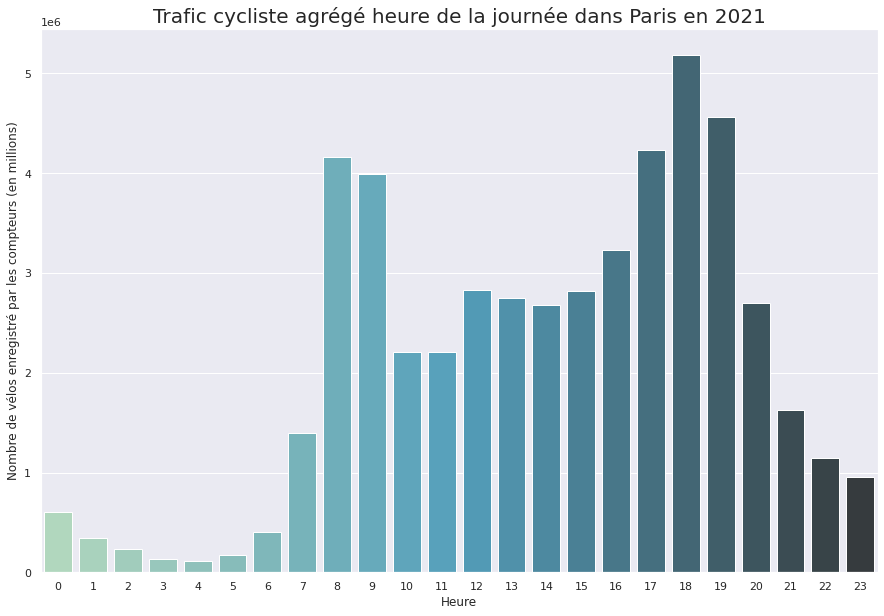

In [ ]:
plt.figure(figsize=(15,10))
sns.barplot(data= df_heure, x= 'Heure', y= 'Comptage horaire', palette= "GnBu_d")
plt.ylabel("Nombre de vélos enregistré par les compteurs (en millions)")
plt.title('Trafic cycliste agrégé heure de la journée dans Paris en 2021', fontsize=20);

## GRAPH 5: 2021 TOP 10 & BOTTOM 10 COMPTEURS

In [ ]:
df_compteur = df_2021.groupby('Nom du compteur', as_index = False).agg({'Comptage horaire' : 'sum'})

Il faut exclure les compteurs qui ont ete installés en 2021 car nous n'avons pas 1 année entière de données

In [ ]:
#df["Date d'installation du site de comptage"].value_counts().index.sort_values()
df_date_instal = df.groupby(["Date d'installation du site de comptage", 'Nom du site de comptage'], as_index = False).agg({'Comptage horaire':'sum'})
df_date_instal

df_date_compteur = df.groupby(["Date d'installation du site de comptage", 'Nom du compteur'], as_index = False).agg({'Comptage horaire':'sum'})
df_date_compteur.loc[df_date_compteur["Date d'installation du site de comptage"].str.contains('2021')]

,Date d'installation du site de comptage,Nom du compteur,Comptage horaire
95,2021-05-18,Quai des Tuileries NO-SE,466078.0
96,2021-05-18,Quai des Tuileries SE-NO,364256.0
97,2021-11-30,30 rue Saint Jacques N-S,142773.0
98,2021-11-30,69 Boulevard Ornano N-S,95095.0


Il y a 4 compteurs qui ont a ete installés en 2021 et que l'on va donc exclure de cette analyse:
* Quai des Tuileries NO-SE
* Quai des Tuileries SE-NO
* 30 rue Saint Jacques N-S
* 69 Boulevard Ornano N-S




In [ ]:
df_for_10 = df_compteur.sort_values(by= 'Comptage horaire', ascending= False)


In [ ]:
df_for_10 = df_for_10.drop(df_for_10[df_for_10['Nom du compteur'] == 'Quai des Tuileries NO-SE'].index, axis= 0 )
df_for_10 = df_for_10.drop(df_for_10[df_for_10['Nom du compteur'] == 'Quai des Tuileries SE-NO'].index, axis= 0 )
df_for_10 = df_for_10.drop(df_for_10[df_for_10['Nom du compteur'] == '30 rue Saint Jacques N-S'].index, axis= 0 )
df_for_10 = df_for_10.drop(df_for_10[df_for_10['Nom du compteur'] == '69 Boulevard Ornano N-S'].index, axis= 0 )


In [ ]:
df_for_10.info()

In [ ]:
df_for_top10 = df_for_10.head(10)
df_for_bottom10 = df_for_10.tail(10)

df_for_bottom10

,Nom du compteur,Comptage horaire
71,Face au 8 avenue de la porte de Charenton NO-SE,152572.0
60,Face au 16 avenue de la Porte des Ternes O-E,98086.0
32,30 rue Saint Jacques N-S (temporaire),81543.0
65,Face au 40 quai D'Issy NE-SO,75712.0
12,16 avenue de la Porte des Ternes E-O,71187.0
66,Face au 40 quai D'Issy SO-NE,59023.0
16,2 avenue de la Porte de Bagnolet O-E,39304.0
30,3 avenue de la Porte D'Orléans S-N,21884.0
28,28 boulevard Diderot E-O,13868.0
76,Pont National SO-NE,4858.0


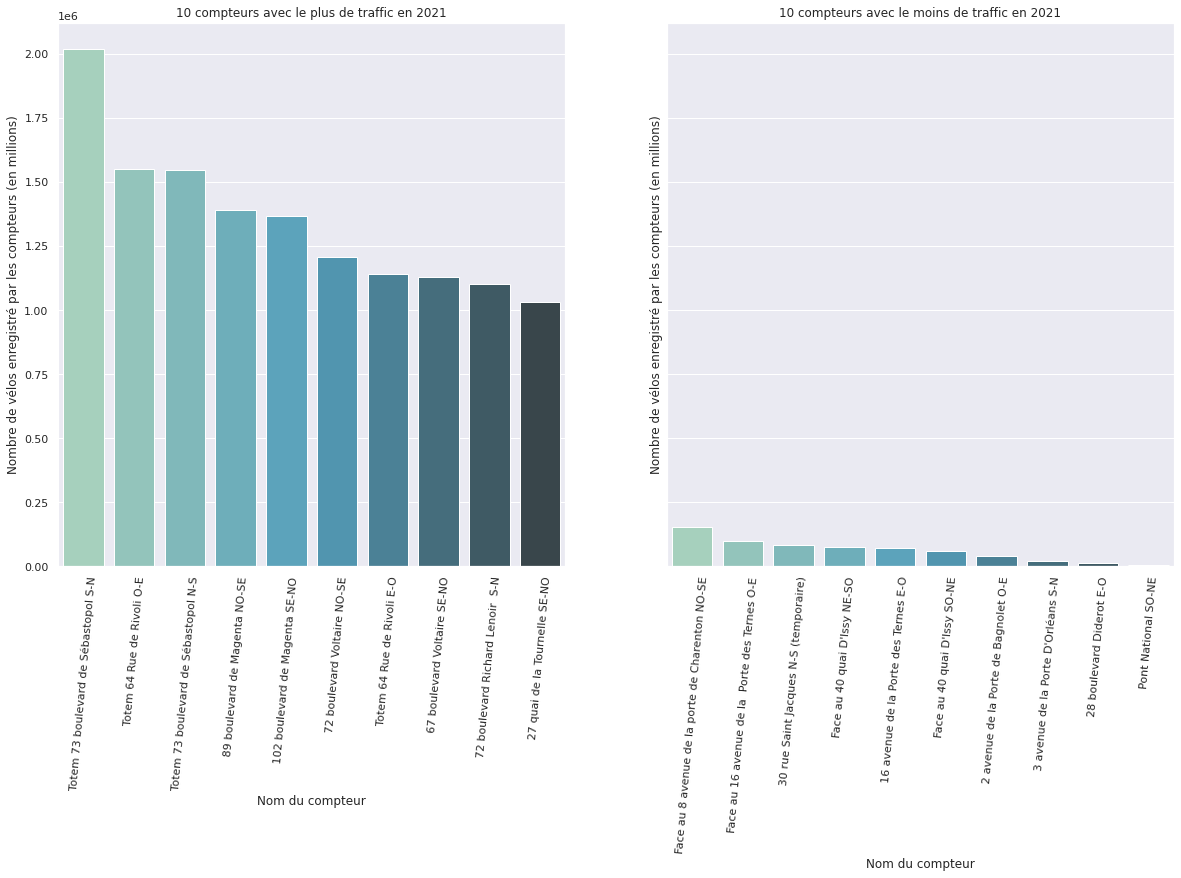

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,10), sharey=True)

sns.barplot(data= df_for_top10, x= 'Nom du compteur', y= 'Comptage horaire', ax=ax1, palette= "GnBu_d")
ax1.title.set_text("10 compteurs avec le plus de traffic en 2021")
ax1.set_ylabel("Nombre de vélos enregistré par les compteurs (en millions)")
ax1.set_xticklabels(ax1.get_xticklabels(),rotation = 85)

sns.barplot(data= df_for_bottom10, x= 'Nom du compteur', y= 'Comptage horaire', ax=ax2, palette= "GnBu_d")
ax2.title.set_text("10 compteurs avec le moins de traffic en 2021")
ax2.set_ylabel("Nombre de vélos enregistré par les compteurs (en millions)")
ax2.set_xticklabels(ax2.get_xticklabels(),rotation = 85);


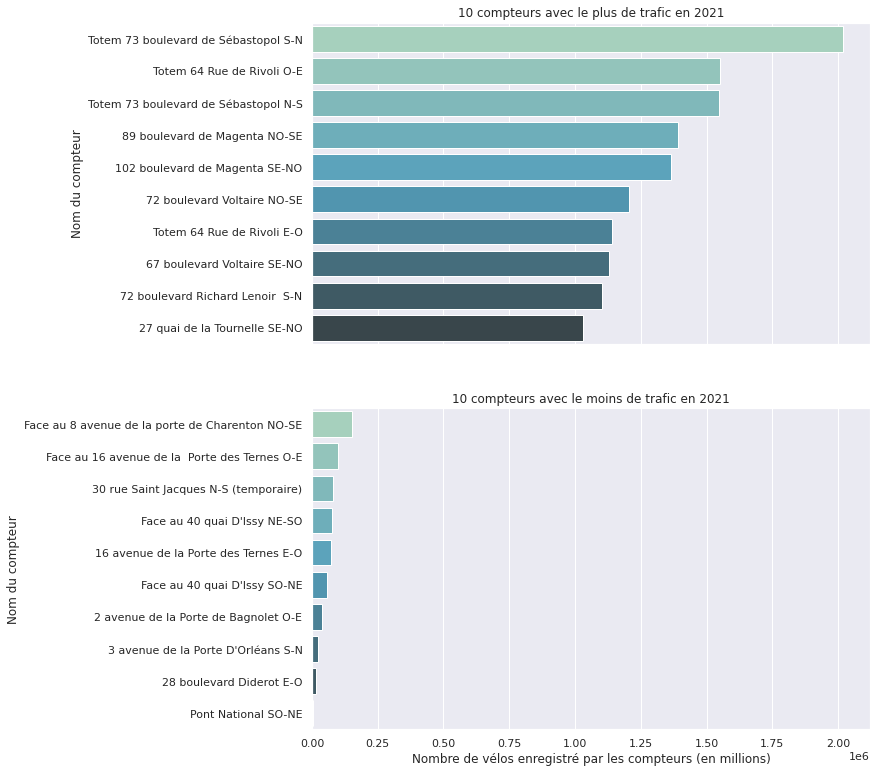

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,13), sharex=True)

sns.barplot(data= df_for_top10, x= 'Comptage horaire', y= 'Nom du compteur', ax=ax1, palette= "GnBu_d")
ax1.title.set_text("10 compteurs avec le plus de trafic en 2021")
ax1.set_xlabel("")

sns.barplot(data= df_for_bottom10, x= 'Comptage horaire', y= 'Nom du compteur', ax=ax2, palette= "GnBu_d")
ax2.title.set_text("10 compteurs avec le moins de trafic en 2021")
ax2.set_xlabel("Nombre de vélos enregistré par les compteurs (en millions)");


In [ ]:
df_pont_nat = df_2021.loc[df_2021["Nom du compteur"] == 'Pont National SO-NE']

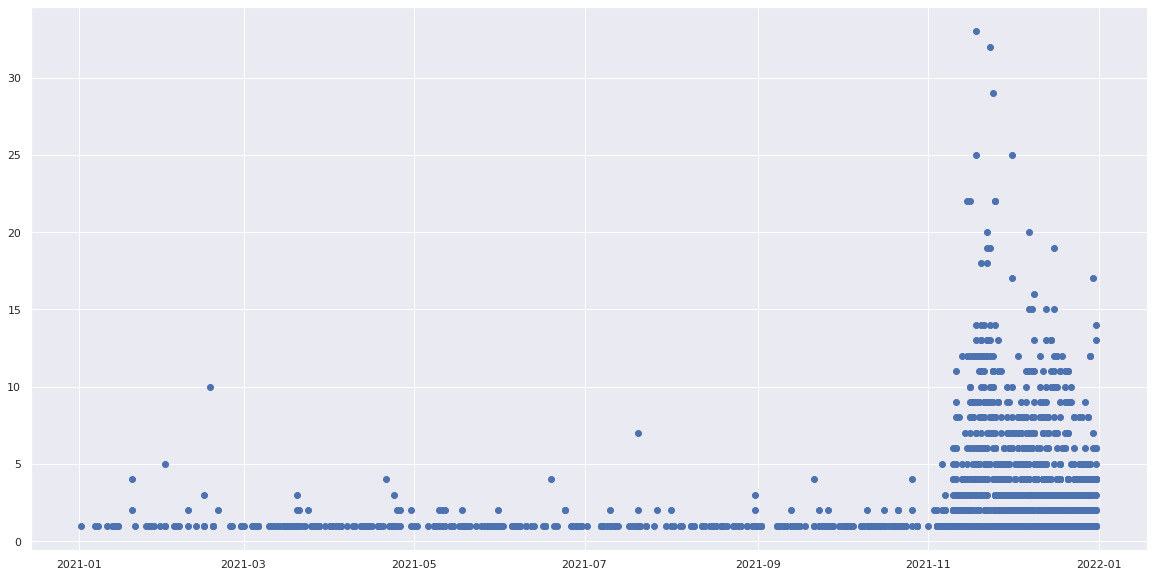

In [ ]:
df_pont_nat.sort_values(by= 'Comptage horaire', ascending= False).head(25)
#df_pont_nat = df_pont_nat.drop(df_pont_nat['Comptage horaire'] == 0, axis= 0)
df_pont_nat = df_pont_nat[df_pont_nat['Comptage horaire'] > 0]
df_pont_nat
plt.figure(figsize= (20,10))
plt.plot_date(data= df_pont_nat, x= 'Date', y= 'Comptage horaire', xdate= True)
# comptage *horraire* d'ou le fait que c'est pas tres beau et qu'il y a bc de point

In [ ]:
df_compteur[df_compteur['Nom du compteur'].str.contains('National')]

,Nom du compteur,Comptage horaire
75,Pont National NE-SO,616486.0
76,Pont National SO-NE,4858.0


Valeurs abérantes pour 'Pont National SO-NE' car non cohérente

## GRAPH 6: JAN 2021 vs JAN 2022

In [ ]:
df_jan_2021 = df.loc[df['Date'].between('2021-01-01', '2021-02-01')]
df_jan_2022 = df.loc[df['Date'].between('2022-01-01', '2022-02-01')]


In [ ]:
df_jan_2021['Jour du mois'] = df_jan_2021['Date'].dt.day

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_jan_2022['Jour du mois'] = df_jan_2022['Date'].dt.day

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_jan_21 = df_jan_2021.groupby(["Jour du mois"], as_index = False).agg({'Comptage horaire':'sum'})
df_jan_22 = df_jan_2022.groupby(["Jour du mois"], as_index = False).agg({'Comptage horaire':'sum'})


Compte tenu du fait que notre jeu de donné contient le trafic enregistré par les compteurs du 01/01/2021 au 31/01/2022, et que nous nous sommes principalement foncalisé sur les données de 2021, il serait interessant de comparer les données de Janvier 2021 avec celle de 2022 pour voir si de 2021 à 2022, nous pouvons observer des tendances.
Par exemple, avec les nombreux nouveaux aménagements faits au niveau des pistes cyclables et autres infrastrctures pour les vélos courant 2021, on peut supposer que le trafic en Janvier 2022 sera plus important qu'en Janvier 2021.

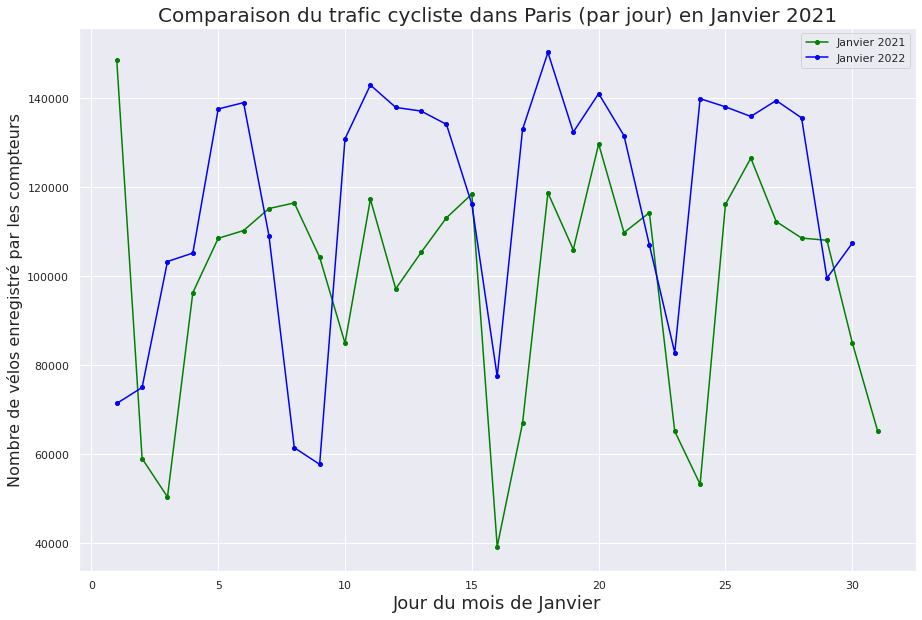

In [ ]:
plt.figure(figsize= (15,10))
plt.plot(df_jan_21['Jour du mois'], df_jan_21['Comptage horaire'], ls= '-', color= 'green', marker= 'o', markersize=4, label= 'Janvier 2021')
plt.plot(df_jan_22['Jour du mois'], df_jan_22['Comptage horaire'], ls= '-', color= 'blue', marker= 'o', markersize=4, label= 'Janvier 2022')
plt.xlabel('Jour du mois de Janvier', fontsize=18)
plt.ylabel('Nombre de vélos enregistré par les compteurs', fontsize=16)
plt.title('Comparaison du trafic cycliste dans Paris (par jour) en Janvier 2021', fontsize=20)
plt.legend();

En analysant le graphe, on peut observer que la tendance entre les deux courbes est similaire mais que les maximums et les minimums sont plus elevés en Janvier 2022 comparé à Janvier 2021.
En faisant les moyennes sur les deux périodes, on voit que la moyenne de Janvier 2022 est nettement plus élevée que Janvier 2021 : 
* moyenne en Jan 2021 : 99,047.0
* moyenne en Jan 2022 : 117009.0

In [ ]:
print('moyenne en 2021 :', round(df_jour_2021['Comptage horaire'].mean(), 0))

print('moyenne en Jan 2021 :', round(df_jan_21['Comptage horaire'].mean(), 0))
print('moyenne en Jan 2022 :', round(df_jan_22['Comptage horaire'].mean(), 0))

print('mediane en Jan 2021 :', round(df_jan_21['Comptage horaire'].median(), 0))
print('mediane en Jan 2022 :', round(df_jan_22['Comptage horaire'].median(), 0))

moyenne en 2021 : 138875.0
moyenne en Jan 2021 : 99047.0
moyenne en Jan 2022 : 117009.0
mediane en Jan 2021 : 108507.0
mediane en Jan 2022 : 131966.0


In [ ]:
df_2021_day = df_2021.groupby(['Mois', 'Jour'], as_index = False).agg({'Comptage horaire':'sum'})

## GRAPH 7: GEO VIZ

### PRE-PROCESSING

How-to and tips taken from : 
* https://towardsdatascience.com/creating-a-simple-map-with-folium-and-python-4c083abfff94
* https://livecodestream.dev/post/how-to-plot-your-data-on-maps-using-python-and-folium/
* https://github.com/python-visualization/folium/issues/1271


In [ ]:
import folium
from folium import plugins
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df_loc_only = df[['Nom du site de comptage', 'Nom du compteur', 'Coordonnées géographiques']]
df_loc_only

,Nom du site de comptage,Nom du compteur,Coordonnées géographiques
0,97 avenue Denfert Rochereau,97 avenue Denfert Rochereau SO-NE,"48.83511,2.33338"
1,97 avenue Denfert Rochereau,97 avenue Denfert Rochereau SO-NE,"48.83511,2.33338"
2,97 avenue Denfert Rochereau,97 avenue Denfert Rochereau SO-NE,"48.83511,2.33338"
3,97 avenue Denfert Rochereau,97 avenue Denfert Rochereau SO-NE,"48.83511,2.33338"
4,97 avenue Denfert Rochereau,97 avenue Denfert Rochereau SO-NE,"48.83511,2.33338"
...,...,...,...
904316,69 Boulevard Ornano N-S,69 Boulevard Ornano N-S,"48.89683,2.34521"
904317,69 Boulevard Ornano N-S,69 Boulevard Ornano N-S,"48.89683,2.34521"
904318,69 Boulevard Ornano N-S,69 Boulevard Ornano N-S,"48.89683,2.34521"
904319,69 Boulevard Ornano N-S,69 Boulevard Ornano N-S,"48.89683,2.34521"


In [ ]:
df_loc_only['Latitude'] = df_loc_only['Coordonnées géographiques'].apply(lambda x: x[:8])

In [ ]:
df_loc_only['Latitude'].replace({'48.8484,':'48.8484'}, inplace= True)
df_loc_only['Latitude'] = df_loc_only['Latitude'].astype(float)

In [ ]:
df_loc_only['Longitude'] = df_loc_only['Coordonnées géographiques'].apply(lambda x: x[-7:])

In [ ]:
df_loc_only['Longitude'].replace({',2.3506':'2.3506', ',2.3497':'2.3497', '6,2.377':'2.377', '1,2.301':'2.301', ',2.3592':'2.3592'}, inplace= True)
df_loc_only['Longitude'] = df_loc_only['Longitude'].astype(float)

In [ ]:
df_loc_only = df_loc_only.drop_duplicates()

In [ ]:
df_loc_only.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99 entries, 0 to 901792
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Nom du site de comptage    99 non-null     object 
 1   Nom du compteur            99 non-null     object 
 2   Coordonnées géographiques  99 non-null     object 
 3   Latitude                   99 non-null     float64
 4   Longitude                  99 non-null     float64
dtypes: float64(2), object(3)
memory usage: 4.6+ KB


### THE ACTUAL MAPS

**MAP1**

In [ ]:
map1 = folium.Map(location=[48.858333, 2.342338], zoom_start=13, control_scale=True)

In [ ]:
for index, location_info in df_loc_only.iterrows():
    folium.Marker([location_info["Latitude"], location_info["Longitude"]], popup=location_info["Nom du site de comptage"]).add_to(map1)

In [ ]:
map1

**MAP 2**

In [ ]:
#map1 = folium.Map(location=[df_loc_only.Lattitude.mean(), df_loc_only.Longitude.mean()], zoom_start=14, control_scale=True)
map3 = folium.Map(location=[48.858333, 2.342338], zoom_start=13, control_scale=True)

In [ ]:
df_loc_heatmap = df_loc_only[['Latitude', 'Longitude']]
heatmap_array = df_loc_heatmap.values


In [ ]:
map3.add_child(plugins.HeatMap(heatmap_array, radius=25))
map3

**MAP 3**

In [ ]:
map5 = folium.Map(location=[48.858333, 2.342338], zoom_start=13, control_scale=True)

In [ ]:
df_heatmap_weight = df.groupby(['Nom du site de comptage', 'Coordonnées géographiques'], as_index = False).agg({'Comptage horaire' : 'sum'})
#df_heatmap_weight = df_heatmap_weight[['Nom du site de comptage', 'Coordonnées géographiques']]


In [ ]:
df_heatmap_weight['Latitude'] = df_heatmap_weight['Coordonnées géographiques'].apply(lambda x: x[:8])

df_heatmap_weight['Latitude'].replace({'48.8484,':'48.8484'}, inplace= True)
df_heatmap_weight['Latitude'] = df_heatmap_weight['Latitude'].astype(float)

In [ ]:
df_heatmap_weight['Longitude'] = df_heatmap_weight['Coordonnées géographiques'].apply(lambda x: x[-7:])

df_heatmap_weight['Longitude'].replace({',2.3506':'2.3506', ',2.3497':'2.3497', '6,2.377':'2.377', '1,2.301':'2.301', ',2.3592':'2.3592'}, inplace= True)
df_heatmap_weight['Longitude'] = df_heatmap_weight['Longitude'].astype(float)

In [ ]:
df_heatmap_weight['Comptage horaire norm'] = df_heatmap_weight['Comptage horaire'] /df_heatmap_weight['Comptage horaire'].sum()

In [ ]:
df_heatmap_weight.head()

,Nom du site de comptage,Coordonnées géographiques,Comptage horaire,Latitude,Longitude,Comptage horaire norm
0,10 avenue de la Grande Armée SE-NO,"48.874716,2.292439",213889.0,48.87471,0.292439,0.003946
1,10 boulevard Auguste Blanqui NE-SO,"48.83068,2.35348",328818.0,48.83068,2.353480,0.006067
2,100 rue La Fayette,"48.87813,2.3497",412391.0,48.87813,2.349700,0.007609
3,102 boulevard de Magenta SE-NO,"48.877726,2.354926",1466319.0,48.87772,0.354926,0.027054
4,105 rue La Fayette E-O,"48.87773,2.3506",824453.0,48.87773,2.350600,0.015211


In [ ]:
heat_data = df_heatmap_weight[['Latitude', 'Longitude', 'Comptage horaire norm']].values.tolist()

In [ ]:
plugins.HeatMapWithTime(heat_data,radius=13).add_to(map5)

In [ ]:
map5